# 1. Założenia
## 1.1 Cel analizy
Globalna firma konsultingowa, zatrudnia programistów specjalizujących się w różnych technologiach i planuje rozszerzyć pakiet swoich usług o doractwo w zakresie baz danych. Aby uzyskać jak największy zwrot inwestycji i zapewnić najłatwiejszy dostęp do specjalistów chce sie dowiedzieć które z wiodących rozwiązań jest najpopularniejsze wśród programistów.

## 1.2 Źródło danych
Jako żródło danych do analizy przyjęto zbiór https://archive.org/download/stackexchange/dba.stackexchange.com.7z zawierający zrzut wszystkich danych z portalu https://dba.stackexchange.com/ będący forum wymiany wiedzy dla specjalistów zajmujących się bazami danych.

## 1.3 Wybór technologii
Do analizy wybranego zbioru wybrano Apache Spark, gdyż:
1. pozwala na efektywne przetwarzanie dużych zbiorów danych, 
2. umożliwia przetwarzanie w pamięci bez potrzeby zrzucania posrednich wyników na dysk co przyspiesza eksplorację i transformację danych,
3. zapewnia przyjazne API w pythonie (PySpark)
4. pozwala skalować zdefiniowane operacje, co umożliwi w przyszłości powtórzenie analizy na dowolnie dużym zbiorze danych o podobnym formacie (inne portale, np. stack overflow)

# 2. Parsowanie danych źródłowych i ETL
Dane z portalu dba.stackexchange są w formacie xml, aby się im przyjrzeć wczytamy je do pamięci za pomocą SparkContext:

In [1]:
import pyspark

sc = pyspark.SparkContext(appName="DBstackex")
#wczytanie pliku Tags.xml do RDD
xml_file = sc.textFile('data/input/Tags.xml')

In [2]:
xml_file.take(4)

['<?xml version="1.0" encoding="utf-8"?>',
 '<tags>',
 '  <row Id="1" TagName="mysql" Count="13032" ExcerptPostId="2667" WikiPostId="2666" />',
 '  <row Id="2" TagName="innodb" Count="1492" ExcerptPostId="3131" WikiPostId="3130" />']

Aby pozbyć się niepotrzebnych tagów xml z poczatku i końca pliku, odfiltrujemy wiersze zaczynające się od "<row"

In [3]:
tags = xml_file.filter(lambda l: l.strip().startswith("<row"))
tags.take(4)

['  <row Id="1" TagName="mysql" Count="13032" ExcerptPostId="2667" WikiPostId="2666" />',
 '  <row Id="2" TagName="innodb" Count="1492" ExcerptPostId="3131" WikiPostId="3130" />',
 '  <row Id="3" TagName="myisam" Count="374" ExcerptPostId="3144" WikiPostId="3143" />',
 '  <row Id="4" TagName="schema" Count="619" ExcerptPostId="4367" WikiPostId="4366" />']

Aby zinterpretować pozostałe tagi xml użyjemy biblioteki "xml.etree.ElementTree" przekształcającej kazdy wiersz na hierarchiczny element zawierający informację o tag'u oraz słownik atrybutów

In [4]:
import xml.etree.ElementTree as ET
elements = tags.map(lambda l: ET.fromstring(l))
#stworzymy nowe RDD składające się ze słowników, każdy zawierający atrybuty elementu row jako klucze oraz wartości atrybutów
keys_values = elements.map(lambda l: l.attrib)
keys_values.take(2)

[{'Count': '13032',
  'ExcerptPostId': '2667',
  'Id': '1',
  'TagName': 'mysql',
  'WikiPostId': '2666'},
 {'Count': '1492',
  'ExcerptPostId': '3131',
  'Id': '2',
  'TagName': 'innodb',
  'WikiPostId': '3130'}]

Element typu row może zawierać dowolną ilość atrybutów. Musimy uzyskac najszerszy zbiór atrybutów występujący w zbiorze, narzucić go wszystkim elementom. Jeżeli jakiś element nie zawierał wczesniej tego atrybutu musimy mu go przypisać z wartością None.

In [5]:
# tworzymy liste unikalnych atrybutów w całym pliku
col_list = list(keys_values.flatMap(lambda d: d.keys()).distinct().toLocalIterator())
col_list

['TagName', 'WikiPostId', 'Count', 'ExcerptPostId', 'Id']

Każdy słownik w naszym obecnym RDD uzupełnimy o brakujące atrybuty i zwrócimy w postaci wiersza, co umożliwi nam przekształcenie RDD do postaci DataFrame. Do tego przeksztacenia zdefiniujemy osobną funkcję:

In [6]:
from pyspark.sql import Row
from collections import OrderedDict

def convert_to_row(d: dict) -> Row:
    dd={}
    for k in col_list:
        if k in d:
            dd[k] = d[k]
        else:
            dd[k] = None
    return Row(**OrderedDict(sorted(dd.items())))

In [7]:
df = keys_values.map(convert_to_row)
df.take(4)

[Row(Count='13032', ExcerptPostId='2667', Id='1', TagName='mysql', WikiPostId='2666'),
 Row(Count='1492', ExcerptPostId='3131', Id='2', TagName='innodb', WikiPostId='3130'),
 Row(Count='374', ExcerptPostId='3144', Id='3', TagName='myisam', WikiPostId='3143'),
 Row(Count='619', ExcerptPostId='4367', Id='4', TagName='schema', WikiPostId='4366')]

Możemy teraz przekształcić RDD do DataFrame aby skorzystać z wysokopoziomowego API i więszej ilości predefiniowanych funckcji. Musimy do tego użyć dostępnego w Spark 2.0 SQLContext.

In [8]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

df=sqlContext.createDataFrame(df, samplingRatio = 0.1)
df.limit(4).toPandas()

,Count,ExcerptPostId,Id,TagName,WikiPostId
0,13032,2667,1,mysql,2666
1,1492,3131,2,innodb,3130
2,374,3144,3,myisam,3143
3,619,4367,4,schema,4366


Aby umożliwić dalsze analizy na zbiorze zapiszemy wszystkie przekształcone dane w postaci parquet. Ten format pozwoli nam zaoszczędzić miejsce na dysku oraz przyspieszy operację wykonywane na całych kolumnach (filtrowanie, aggregacje).

In [9]:
#df.coalesce(1).write.parquet("data/results/Posts_parquet")

Podobny pipeline czyszczący dane zostanie użyty do przetworzenia pozostałych plików xml.

In [10]:
xml_file=sc.textFile('data/input/Posts.xml')
tags=xml_file.filter(lambda l: l.strip().startswith("<row"))
elements = tags.map(lambda l: ET.fromstring(l))
keys_values = elements.map(lambda l: l.attrib)
col_list = list(keys_values.flatMap(lambda d: d.keys()).distinct().toLocalIterator())
df = keys_values.map(convert_to_row)
df=sqlContext.createDataFrame(df, samplingRatio = 0.1)

# 3. Czyszczenie danych
## 3.1 Tagi
Ponieważ interesują nas tylko wiodące technologie bazodanowe, musimy ustalić ja najpierw określić na podstawie ilości postów z tagiem definiującym przynależność tematyczną postu do danej technologii.

In [12]:
df = sqlContext.read.json("./data/results/Tags/part-00000")
df.limit(4).toPandas()

,Count,ExcerptPostId,Id,TagName,WikiPostId
0,13032,2667,1,mysql,2666
1,1492,3131,2,innodb,3130
2,374,3144,3,myisam,3143
3,619,4367,4,schema,4366


Interesuje nas kolumna TagName i Count. Posortujemy je w/g malejącej wartości Count.

In [13]:
from pyspark.sql.functions import col

new_df=df.select("TagName", "Count") \
    .withColumn("Count", df["Count"].cast('int')) \
    .sort(col("Count").desc())
new_df.limit(10).toPandas()

,TagName,Count
0,sql-server,17351
1,mysql,13032
2,sql,7966
3,postgresql,6160
4,oracle,4720
5,database-design,3517
6,sql-server-2008,3433
7,sql-server-2008-r2,3264
8,sql-server-2012,3199
9,performance,2066


Jak widać najpopularniejszymi technologiami są: "sql-server", "mysql", "postgres", oraz "oracle". Chcielibyśmy jednak aby np. sql-server-2008 był zaklasyfikowany jako technologia sql-server. Oprócz tego np.: "rman" jest narzędziem Oracle do buck-up'ów, "t-sql" językiem programowania w środowisku sql-server, a "pgadmin" i "phpmyadmin" to popularne klienty bazy postgres. Aby ustandaryzować tagi, korzystając z wiedzy domenowej zbudujemy słownik tłumaczący różne tagi związane z daną technologią na tag danej technologii:

In [14]:
tag_dict = {
    "mysql.*": "mysql",
    "innodb": "mysql",
    "myisam": "mysql",
    "sql-server.*": "sql-server",
    "ssms": "sql-server",
    "ssis": "sql-server",
    "t-sql": "sql-server",
    "postgresql.*": "postgres",
    "oracle.*": "oracle",
    "document-oriented":"mongodb",
    "phpmyadmin": "postgres",
    "plsql": "oracle",
    "plpgsql": "postgres",
    "sqlplus": "oracle",
    "rman": "oracle",
    "pgadmin": "postgres",
    "windows-server.*":"sql-server",
    "pg-dump": "postgres",
    "psql": "postgres",
    "postgis": "postgres",
    "nosql": "mongodb",
    "mongo.*": "mongodb"
        }

Aby ustandaryzować tagi w/g powyższego słownika stworzymy funkcję operującą na kolumnie TagName:

In [15]:
import pyspark.sql.functions as func
def standardize_tags(col):
    for i in tag_dict:
        col=func.regexp_replace(col, i, tag_dict[i])
    return col
#lista unikatowych tagów po standaryzacji
tag_list=list(tag_dict.values())

In [16]:
df_standard = new_df \
.withColumn('TagName_std', standardize_tags('TagName'))
#odfiltrujmy tagi nie znajdujące się w słowniku
df_filtered = df_standard \
.filter(df_standard.TagName_std.isin(tag_list)==True)
df_filtered.limit(10).toPandas()

,TagName,Count,TagName_std
0,sql-server,17351,sql-server
1,mysql,13032,mysql
2,postgresql,6160,postgres
3,oracle,4720,oracle
4,sql-server-2008,3433,sql-server
5,sql-server-2008-r2,3264,sql-server
6,sql-server-2012,3199,sql-server
7,t-sql,1552,sql-server
8,innodb,1492,mysql
9,sql-server-2014,1467,sql-server


Przeanalizujmy top 5 technologii pod względem ilości traktujących o niej postów.

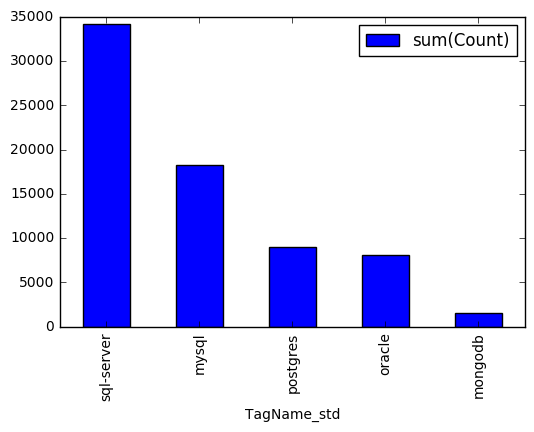

In [17]:
df_aggr=df_filtered.groupBy("TagName_std") \
.agg(func.sum("Count")).sort(col("sum(Count)").desc())

%matplotlib inline
pdf=df_aggr.toPandas().plot(x="TagName_std", y="sum(Count)", kind="bar")

Widzimy, że na piątym miejscu znalazło sie MongoDB. Ponieważ zdecydowanie odstaje od pozostałych technologii pod wzgledem popularności oraz jako jedyna baza typu NoSQL nie jest skierowana to tego samego targetu rynkowego co pozostałe bazy, w dalszej analizie zostanie pominięta.

## 3.2 Posty
Przyjżyjmy się tabeli Posts. Zrzutujmy kolumny wczytane z formatu parquet na odpowiednie typy danych.

In [18]:
df = sqlContext.read.parquet("./data/results/Posts_parquet/Posts.parquet")
tags_df=df \
.select(df["Id"].cast('int'), 
        df["Tags"], 
        df["CreationDate"].cast('date'), 
        df['LastEditDate'].cast('date'))
tags_df.limit(5).toPandas()

,Id,Tags,CreationDate,LastEditDate
0,1,<mysql><innodb><myisam>,2011-01-03,None
1,2,<mysql><version-control><schema>,2011-01-03,2011-01-06
2,3,<database-design><erd>,2011-01-03,2011-01-06
3,4,None,2011-01-03,2013-09-23
4,5,<nosql><rdbms><database-recommendation>,2011-01-03,2011-01-06


Musimy dokonać podobnej standaryzacji kolumny "Tags" jak w przypadku tabeli "Tags". W tym przypadku problem jest bardziej skomplikowany ponieważ kolumna może zawierać 0..n tagów w jednym rekordzie. Bedziemy musieli zmodyfikować funkcję standaryzującą. 

In [19]:
def standardize_tags(tag_list):
    import re
    tags_std = tag_list
    for key, value in tag_dict.items():
        regex = re.compile(key, re.IGNORECASE)
        tags_std=[regex.sub(value, tag) for tag in tags_std]
    return tags_std

Odfiltrujmy rekordy nie zawierające żadnego tagu ("None") i przekształcimy zawartość kolumny do formatu zbioru tagów.

In [20]:
tags_rdd=tags_df.rdd
tags_rdd.count()

127212

In [21]:
tags_not_empty=tags_rdd.filter(lambda x: x[1]!=None)
tags_not_empty.count()

53664

In [22]:
#usuwanie niepotrzebnych znaków
tags_clean=tags_not_empty \
.map(lambda x: (x[0], x[1].replace('><',', '), x[2], x[3])) \
.map(lambda x: (x[0], x[1].replace('<', ''), x[2], x[3])) \
.map(lambda x: (x[0], x[1].replace('>', ''), x[2], x[3]))
#podział ciągu znaków na elementy listy
tags_split=tags_clean \
.map(lambda x: (x[0], x[1].split(','), x[2], x[3])) \
.map(lambda x: (x[0], [e.strip() for e in x[1]], x[2], x[3]))
#standaryzowanie tagów
tags_standardized=tags_split \
.map(lambda x: (x[0], standardize_tags(x[1]), x[2], x[3]))
#przekształcenie listy tagów na zbiór do dalszych operacji
tags_unique = tags_standardized \
.map(lambda x: (x[0],set(x[1]), x[2], x[3]))

tags_unique.take(4)

[(1, {'mysql'}, datetime.date(2011, 1, 3), None),
 (2,
  {'mysql', 'schema', 'version-control'},
  datetime.date(2011, 1, 3),
  datetime.date(2011, 1, 6)),
 (3,
  {'database-design', 'erd'},
  datetime.date(2011, 1, 3),
  datetime.date(2011, 1, 6)),
 (5,
  {'database-recommendation', 'mongodb', 'rdbms'},
  datetime.date(2011, 1, 3),
  datetime.date(2011, 1, 6))]

In [23]:
#unikatowe tagi w słowniku standaryzującym
unique_tags=set(tag_dict.values())
unique_tags

{'mongodb', 'mysql', 'oracle', 'postgres', 'sql-server'}

Odfiltrowanie rekordów które nie zawierają żadnego z tagów w słowniku

In [24]:
post_tags_meaningful = tags_unique \
.map(lambda x: (x[0],x[1].intersection(unique_tags), x[2], x[3])) \
.filter(lambda x: bool(x[1]))
post_tags_meaningful.take(4)

[(1, {'mysql'}, datetime.date(2011, 1, 3), None),
 (2, {'mysql'}, datetime.date(2011, 1, 3), datetime.date(2011, 1, 6)),
 (5, {'mongodb'}, datetime.date(2011, 1, 3), datetime.date(2011, 1, 6)),
 (6, {'postgres'}, datetime.date(2011, 1, 3), datetime.date(2011, 8, 16))]

Musimy jeszcze poradzić sobie z rekordami zawierającymi więcej niż jeden tag z zakresu naszego zainteresowania, na przykład:

In [25]:
common_tags = post_tags_meaningful.filter(lambda x: len(x[1])>1)
common_tags.take(3)

[(96,
  {'mysql', 'postgres'},
  datetime.date(2011, 1, 4),
  datetime.date(2011, 8, 16)),
 (287, {'oracle', 'sql-server'}, datetime.date(2011, 1, 5), None),
 (297,
  {'oracle', 'sql-server'},
  datetime.date(2011, 1, 5),
  datetime.date(2011, 1, 10))]

Najpierw narzućmy typy danych w naszym RDD i zrzućmy na dysk stransformowaną wersję danych do dalszej obróki

In [26]:
from pyspark.sql.types import *
from pyspark.sql.functions import when
import datetime

post_tags_to_write=post_tags_meaningful \
.map(lambda x: (x[0],list(x[1]), x[2], x[3]))

fields = [
    StructField('Id', IntegerType(), True),
    StructField('Tags', ArrayType(StringType(), True), True),
    StructField('CreationDate', DateType(), True),
    StructField('LastEditDate', DateType(), True)]
schema = StructType(fields)
df=sqlContext.createDataFrame(post_tags_to_write, schema, samplingRatio = 0.1)
df_filled = df \
.withColumn('LastEditDate', when(
        col('LastEditDate').isNull(), datetime.date.today()).otherwise(col('LastEditDate')))
df_filled.show(5)

+---+----------+------------+------------+
| Id|      Tags|CreationDate|LastEditDate|
+---+----------+------------+------------+
|  1|   [mysql]|  2011-01-03|  2017-05-28|
|  2|   [mysql]|  2011-01-03|  2011-01-06|
|  5| [mongodb]|  2011-01-03|  2011-01-06|
|  6|[postgres]|  2011-01-03|  2011-08-16|
| 14|   [mysql]|  2011-01-03|  2011-08-16|
+---+----------+------------+------------+
only showing top 5 rows



In [28]:
#df_filled.coalesce(1).write.parquet("data/results/Posts_clean_parquet")

Użyjemy funkcji explode żeby z rekordu z dwoma tagami utworzyć 2 rekordy z każdym tagiem z osobna

In [29]:
posts = sqlContext.read.parquet("./data/results/Posts_clean_parquet/Posts.parquet")
from pyspark.sql.functions import explode
posts=posts.select('Id', explode(col('Tags')).alias('Tag'), 'CreationDate', 'LastEditDate')

Stworzymy wykres ilustrujący ilość tworzonych postów w ciągu roku aby zbadać ogólny trend dla konkretnej technologii. W tym celu dokonamy kilku przeksztaceń:

In [30]:
posts_for_df=posts.filter('Tag = "sql-server"') \
.filter("CreationDate < cast('2017-01-01' as date)") \
.filter("CreationDate > cast('2011-01-01' as date)") \
.select('CreationDate').sort(col('CreationDate'))

In [31]:
df=posts_for_df.toPandas()
df[:5]

,CreationDate
0,2011-01-03
1,2011-01-03
2,2011-01-03
3,2011-01-03
4,2011-01-04


In [34]:
from matplotlib import pyplot as plt 
import seaborn as sns
plt.style.use('fivethirtyeight')

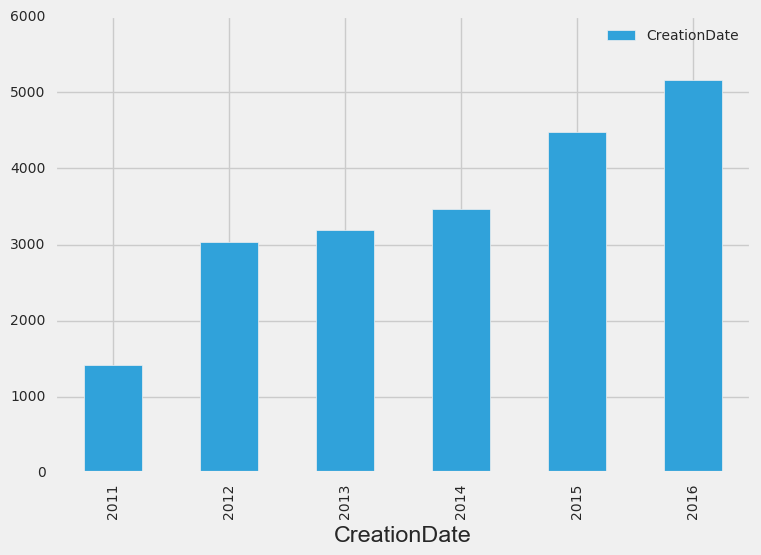

In [40]:
import pandas as pd
df['CreationDate']=pd.to_datetime(df['CreationDate'], format= '%Y-%m-%d')
df.groupby(df["CreationDate"].dt.year).count().plot(kind="bar")

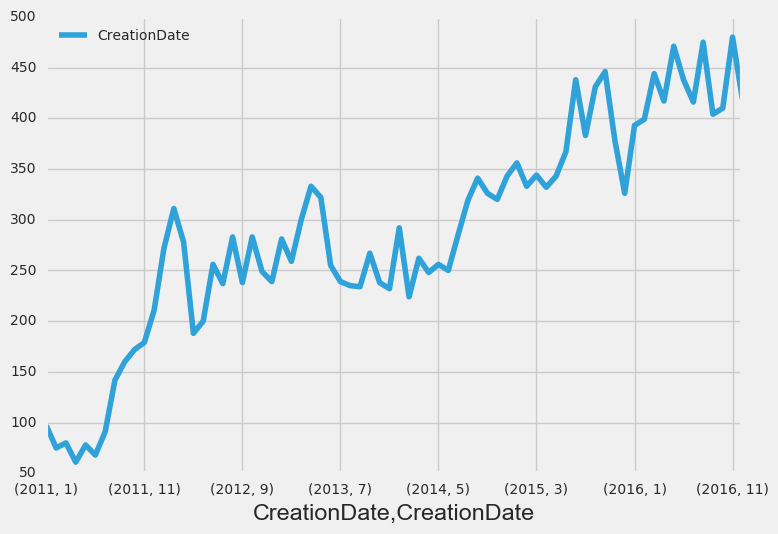

In [41]:
df.groupby([df["CreationDate"].dt.year, df["CreationDate"].dt.month]).count().plot(kind="line")

# 4. Analiza trendu
Źeby skwantyfikować wzrost popularności danej technologii oraz dokonać predykcji trendu na przyszłość skorzystamy z algorytmu regresji liniowej. Poziom granulacji na jakim będziemy badać trend ustalmy na miesiąc.

In [42]:
import datetime
from pyspark.sql.functions import date_format

posts_aggr=posts.filter('Tag = "sql-server"') \
.filter("CreationDate < cast('2017-01-01' as date)") \
.filter("CreationDate > cast('2011-01-01' as date)") \
.select('CreationDate') \
.groupBy(date_format('CreationDate', 'YYYY-MM') \
                                .alias('CreationMonth')) \
.agg({'CreationDate' : 'count'}) \
.select(col('CreationMonth').cast('date'), col('count(CreationDate)') \
        .alias('PostCount')) \
.orderBy('CreationMonth')

In [43]:
posts_aggr.limit(5).toPandas()

,CreationMonth,PostCount
0,2011-01-01,97
1,2011-02-01,75
2,2011-03-01,80
3,2011-04-01,61
4,2011-05-01,78


In [44]:
posts_aggr.dtypes

[('CreationMonth', 'date'), ('PostCount', 'bigint')]

Na potrzeby modelu liniowej regresji potrzebujemy przekształcić wartość typu "date" na wartość typu "int". Użyjemy do tego formatu daty typu unix_timestamp, czyli epoch (sekundy od 1970-01-01)

In [47]:
from pyspark.sql.functions import unix_timestamp
posts_aggr_cast=posts_aggr \
.select(col('CreationMonth'), col('PostCount')) \
.withColumn(
    'CreationMonth', unix_timestamp(posts_aggr.CreationMonth, 'yyyy-MM-dd'))
posts_aggr_cast.show(5)

+-------------+---------+
|CreationMonth|PostCount|
+-------------+---------+
|   1293836400|       97|
|   1296514800|       75|
|   1298934000|       80|
|   1301608800|       61|
|   1304200800|       78|
+-------------+---------+
only showing top 5 rows



In [48]:
posts_aggr_cast.dtypes

[('CreationMonth', 'bigint'), ('PostCount', 'bigint')]

Teraz, tak przygotowane dane możemy podać do modelu liniowej regresji:

In [50]:
from pyspark.ml.feature import VectorAssembler
t = VectorAssembler(inputCols=['CreationMonth'], outputCol = 'features')
training = t.transform(posts_aggr_cast)\
            .withColumn('CreationMonth',posts_aggr_cast.CreationMonth)\
            .withColumn('label',posts_aggr_cast.PostCount)
        
training.toPandas()[:5]

,CreationMonth,PostCount,features,label
0,1293836400,97,[1293836400.0],97
1,1296514800,75,[1296514800.0],75
2,1298934000,80,[1298934000.0],80
3,1301608800,61,[1301608800.0],61
4,1304200800,78,[1304200800.0],78


In [51]:
from pyspark.sql.types import Row

#dane treningowe
training_yrs = training.select('CreationMonth').rdd.map(lambda x: x[0]).collect()
training_y = training.select('PostCount').rdd.map(lambda x: x[0]).collect()

Stwórzmy liste misięcy dla których chcemy dokonać predykcji trendu. Są to miesiące dla 3 kolejnych lat: 2017, 2018, 2019. Daty musimy przedstawić w formacie typu epoch.

In [52]:
import calendar
prediction_yrs=[]
for i in range(36):
    yrs = 2017 + int(i/12)
    mths = i%12 + 1
    prediction_yrs \
    .append(calendar.timegm(datetime.date(yrs,mths,1).timetuple()))
    
all_yrs = training_yrs + prediction_yrs

Dopasujmy model liniowej regresji do wykresu otrzymanego na końcu podrozdziału 3.2, żeby zamodelować trend popularności danej technologii na kolejne 3 lata.
Zakładam przy tym w miare liniowy wzrost popularności dla 6 lat 2011-2017. Jest to bardzo grube założenie, ale da nam liczbową miarę dzięki której bedziemy mogli porównać trend dla różnych technologii.

In [54]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(training)

Przetestujmy działanie modelu na wygenerowanym setcie danych dla przyszłych lat.

In [59]:
test_rdd = sc.parallelize(all_yrs)
row = Row('CreationMonth')
all_years_features = t.transform(test_rdd.map(row).toDF())
df_results = lrModel.transform(all_years_features).toPandas()
df_results[25:32]

,CreationMonth,features,prediction
25,1359673200,[1359673200.0],240.084781
26,1362092400,[1362092400.0],244.324363
27,1364767200,[1364767200.0],249.011876
28,1367359200,[1367359200.0],253.554285
29,1370037600,[1370037600.0],258.248108
30,1372629600,[1372629600.0],262.790516
31,1375308000,[1375308000.0],267.484339


Wróćmy z formatem dat do czytelnej postaci

In [63]:
df_results['CreationMonth']=pd \
.to_datetime(df_results['CreationMonth'], unit='s')
df_results[5:10]

,CreationMonth,features,prediction
5,2011-05-31 22:00:00,[1306879200.0],147.564748
6,2011-06-30 22:00:00,[1309471200.0],152.107156
7,2011-07-31 22:00:00,[1312149600.0],156.800979
8,2011-08-31 22:00:00,[1314828000.0],161.494801
9,2011-09-30 22:00:00,[1317420000.0],166.037210


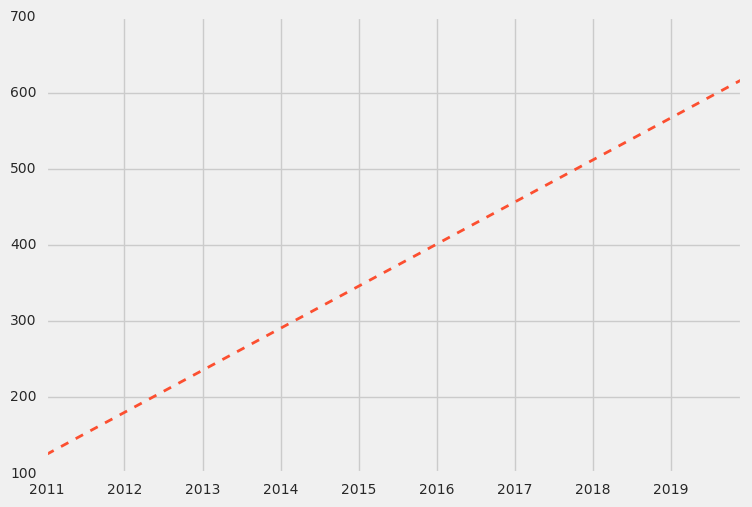

In [65]:
plt.plot(
    df_results.CreationMonth,
    df_results.prediction, 
    linewidth = 2, 
    linestyle = '--',
    color = '#fc4f30', 
    label = 'L2 Fit')